## Task 1

In [47]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

## Task 2

In [26]:
import pandas as pd

# Try to read the active power data from the file, if it doesn't exist, read the original data and save the active power data to a file
try:
    dataset = pd.read_csv('data/active_power.csv')
    dataset["ts"] = pd.to_datetime(dataset["ts"])
    dataset = dataset.set_index("ts")
except FileNotFoundError:
    dataset = pd.read_csv('data/Energydata.csv')
    dataset["ts"] = pd.to_datetime(dataset["ts"])
    dataset = dataset.set_index("ts")
    dataset = dataset.resample("1H").mean()
    dataset = dataset.loc[:, 'Snorrebakken sterled Active Power | sno_ost_effekt | 804131']
    dataset.to_csv('data/active_power.csv')

array([<Axes: xlabel='ts'>], dtype=object)

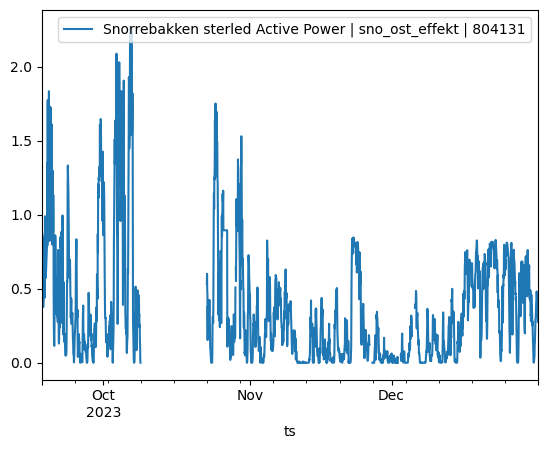

In [27]:
# Plot each column in its own plot
dataset.plot(subplots=True)

67
0
(78, 24)
(78, 24)


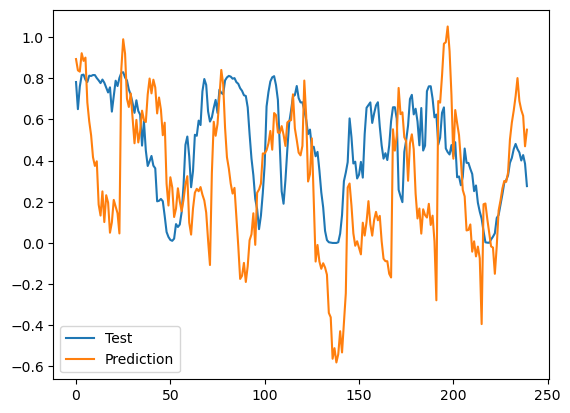

In [60]:
dataset = dataset.loc[dataset.index >= pd.Timestamp("2023-10-01")]

# Group the data by day and create pivot table
table = pd.pivot_table(dataset, index=dataset.index.date, columns=dataset.index.hour, values='Snorrebakken sterled Active Power | sno_ost_effekt | 804131', aggfunc='mean')

# Count the number of NaN values in the table
print(table.isna().sum().sum())

# Fill NaN values with the mean of the column
table = table.fillna(table.mean())
print(table.isna().sum().sum())


X = table.iloc[:-1,:].values
print(X.shape)

Y = table.iloc[1:,:].values
print(Y.shape)

# Split into training and test data
X_train = X[:-10,:]
Y_train = Y[:-10,:]
X_test = X[-10:,:]
Y_test = Y[-10:,:]

theta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ Y_train

Y_pred = X_test @ theta

# Plot the training, test and prediction data with the arrays flattened
import matplotlib.pyplot as plt
plt.plot(Y_test.flatten(), label="Test")
plt.plot(Y_pred.flatten(), label="Prediction")
plt.legend()
plt.show()
